## stacking 集成算法-只有付费记录：线性模型
基础学习器抽取特征，次级学习器融合。5折。
- 1.Lasso回归
- 2.岭回归
- 3.ElasticNetCV

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
from IPython.display import display

#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

In [2]:
def get_train_val(val_id):
    '''获取训练集和校验集 
    val_id = 0,1,2 #当前校验集编号 '''
    print('val_id=%s'% (val_id))
    df_val = train_list[val_id]
    train_tmp = []

    for i in range(1, train_part_num):
        cur_id = (val_id + i) % 5
        print('cur_id=%s'% (cur_id))
        train_tmp.append(train_list[cur_id])
    
#     只生成一次，节省内存 
    df_train = pd.concat(train_tmp)
    print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))
    return df_train, df_val

In [3]:
Y_Standard = True
path_train = '../../data/new/train=all-balance/'
path_test = '../../data/new/test/'

val_path = '../../data/val/payBase/' #保存校验集测试结果
val_name = '%sval=stacking-%s-%s.csv'
summit_path = '../../data/summit/payBase/' #保存提交文件，测试集测试结果 
out_name = '%ssummit=stacking-%s-%s.csv' # 生成的结果文件名称
base = 'payBase' #学习器级别 : 付费记录，基础学习器

train_part_num = 5 #训练集拆分个数
target = 'prediction_pay_price'
user_id = 'user_id'

## 指定读取数据类型，节省内存

In [4]:
col_int32 = ['user_id', 'register_time', 'wood_add_value', 'wood_reduce_value',
       'stone_add_value', 'stone_reduce_value', 'ivory_add_value',
       'ivory_reduce_value', 'meat_add_value', 'meat_reduce_value',
       'magic_add_value', 'magic_reduce_value', 'infantry_add_value',
       'infantry_reduce_value', 'cavalry_add_value', 'cavalry_reduce_value',
       'shaman_add_value', 'shaman_reduce_value', 'wound_infantry_add_value',
       'wound_infantry_reduce_value', 'wound_cavalry_add_value',
       'wound_cavalry_reduce_value', 'wound_shaman_add_value',
       'wound_shaman_reduce_value', 'general_acceleration_add_value',
       'general_acceleration_reduce_value', 'building_acceleration_add_value',
       'building_acceleration_reduce_value', 'reaserch_acceleration_add_value',
       'reaserch_acceleration_reduce_value', 'training_acceleration_add_value',
       'training_acceleration_reduce_value', 'treatment_acceleraion_add_value',
       'treatment_acceleration_reduce_value', 'bd_training_hut_level',
       'bd_healing_lodge_level', 'bd_stronghold_level',
       'bd_outpost_portal_level', 'bd_barrack_level',
       'bd_healing_spring_level', 'bd_dolmen_level', 'bd_guest_cavern_level',
       'bd_warehouse_level', 'bd_watchtower_level', 'bd_magic_coin_tree_level',
       'bd_hall_of_war_level', 'bd_market_level', 'bd_hero_gacha_level',
       'bd_hero_strengthen_level', 'bd_hero_pve_level', 'sr_scout_level', 
       'sr_training_speed_level', 'sr_infantry_tier_2_level',
       'sr_cavalry_tier_2_level', 'sr_shaman_tier_2_level',
       'sr_infantry_atk_level', 'sr_cavalry_atk_level', 'sr_shaman_atk_level',
       'sr_infantry_tier_3_level', 'sr_cavalry_tier_3_level',
       'sr_shaman_tier_3_level', 'sr_troop_defense_level',
       'sr_infantry_def_level', 'sr_cavalry_def_level', 'sr_shaman_def_level',
       'sr_infantry_hp_level', 'sr_cavalry_hp_level', 'sr_shaman_hp_level',
       'sr_infantry_tier_4_level', 'sr_cavalry_tier_4_level',
       'sr_shaman_tier_4_level', 'sr_troop_attack_level',
       'sr_construction_speed_level', 'sr_hide_storage_level',
       'sr_troop_consumption_level', 'sr_rss_a_prod_levell',
       'sr_rss_b_prod_level', 'sr_rss_c_prod_level', 'sr_rss_d_prod_level',
       'sr_rss_a_gather_level', 'sr_rss_b_gather_level',
       'sr_rss_c_gather_level', 'sr_rss_d_gather_level', 'sr_troop_load_level',
       'sr_rss_e_gather_level', 'sr_rss_e_prod_level',
       'sr_outpost_durability_level', 'sr_outpost_tier_2_level',
       'sr_healing_space_level', 'sr_gathering_hunter_buff_level',
       'sr_healing_speed_level', 'sr_outpost_tier_3_level',
       'sr_alliance_march_speed_level', 'sr_pvp_march_speed_level',
       'sr_gathering_march_speed_level', 'sr_outpost_tier_4_level',
       'sr_guest_troop_capacity_level', 'sr_march_size_level',
       'sr_rss_help_bonus_level', 'pvp_battle_count', 'pvp_lanch_count',
       'pvp_win_count', 'pve_battle_count', 'pve_lanch_count', 'pve_win_count',
       'pay_count']
col_float32 = ['avg_online_minutes', 'pay_price']

In [5]:
# 指定读取数据类型，节省内存
dtype_test = {}
for col in col_int32:
    dtype_test[col] = np.int32
for col in col_float32:
    dtype_test[col] = np.float32
# dtype_test

In [6]:
dtype_train = dtype_test.copy()
dtype_train[target] = np.float32
# dtype_train

## 读取数据，一次读取多次使用，不同组合 

In [7]:
train_list = []
for i in range(train_part_num):
    cur_id = i + 1
    train_list.append(pd.read_csv('%strain=pay-%s.csv' % (path_train, cur_id), dtype=dtype_train))
train_list[0].head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,563914,112,1007159,985765,88000,40000,3000,0,1290490,1006267,...,7,4,5,7,7,4,20.3333,1.9900,1,1.9900
1,1837494,106,50141850,50032020,42832440,42426724,23950932,19820632,46290384,37001236,...,1,0,0,21,21,19,105.1667,346.7900,21,346.7900
2,1775165,125,26860392,26935700,17661758,17542478,7595453,2596600,34394904,26972670,...,527,476,504,233,230,216,845.1667,7.9600,4,16.9100
3,3038897,118,1385557,354561,1200000,0,700000,0,2960605,280514,...,7,0,1,0,0,0,2.3333,0.9900,1,0.9900
4,285815,119,7800157,7032101,3436232,1893276,1478472,0,11743239,5703664,...,20,1,2,148,148,145,233.5000,1.9800,2,3.9700


## 5折交叉验证

In [8]:
# 根据校验集编号 0，1,2,3,4 ，获取训练集和校验集
df_train, df_val = get_train_val(2)

# 从原始数据中分离输入特征x和输出y
train_y = df_train[target].values
train_X = df_train.drop([target, user_id], axis = 1)
val_y = df_val[target].values
val_X = df_val.drop([target, user_id], axis = 1)

val_id=2
cur_id=3
cur_id=4
cur_id=0
cur_id=1
df_train.shape=(36790, 109)  df_val.shape=(9198, 109)


In [9]:
# 数据标准化：分别初始化对特征和目标值的标准化器 
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X_ss = ss_X.fit_transform(train_X)
val_X_ss = ss_X.transform(val_X)

if Y_Standard:
    train_y_ss = ss_y.fit_transform(train_y.reshape(-1, 1))
    val_y_ss = ss_y.transform(val_y.reshape(-1, 1))

# 需要转换为一维数组 
train_y_ss_1d = train_y_ss.reshape(train_y_ss.shape[0])
val_y_ss_1d = val_y_ss.reshape(val_y_ss.shape[0])

In [10]:
def inverse_StandardScaler(predict):
    ''' 标准化数据还原  '''
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

def generate_summit(predict):
    ''' 输出预测后的数据 '''
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

def generate_val_predict(predict):
    ''' 生成校验集预测后的数据 '''
    testPredict = df_val.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 模型训练
### 1.正则化的线性回归（L1正则 --> Lasso）

In [11]:
%%time
# alphas = [0.1, 10, 100, 1000, 10000]
alphas = [0.01, 0.02, 0.03, 0.04, 0.05]

lasso = LassoCV(alphas=alphas)
lasso.fit(train_X_ss, train_y_ss_1d)
print ('best_alpha=', lasso.alpha_)

best_alpha= 0.03
Wall time: 508 ms


best alpha is: 0.03


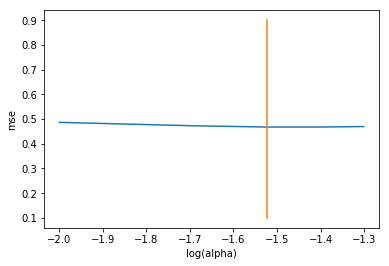

In [12]:
## 3.1 Lasso 模型评价
mses = np.mean(lasso.mse_path_, axis=1)

#plt.plot(np.log10(alphas), mses)
plt.plot(np.log10(lasso.alphas_), mses)
# plt.show()  #绘制在一张图上，显示异常，暂时分开 

plt.plot(np.log10(lasso.alpha_)*np.ones(3), [0.1, 0.5, 0.9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
# plt.show() 
print ('best alpha is:', lasso.alpha_)
# best alpha is: 10.5

In [13]:
# 模型评估
lassoScoreTrain = lasso.score(train_X_ss, train_y_ss)
lassoScoreVal = lasso.score(val_X_ss, val_y_ss)
print('The score: Train=%s  Val=%s'% (lassoScoreTrain, lassoScoreVal)) 

lasso_predict_train = lasso.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss, lasso_predict_train) ** 0.5
lasso_predict_val = lasso.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss, lasso_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6026498641616385  Val=0.8354317552131078
# The RMSE: Train=0.6303571494306712  Val=0.5921995943739873

The score: Train=0.5582304195437819  Val=0.48342231314309325
The RMSE: Train=0.6646574484534975  Val=0.6393728260544682


### 保存校验集测试结果

In [14]:
print('lasso_predict_val= ', lasso_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(lasso_predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'lasso'), index=False)
valPredict.head()

lasso_predict_val=  [-0.12760575 -0.08131725 -0.1332463  ... -0.12746661 -0.11057853
 -0.07659961]
predict =  [ 8.48540453 37.69351493  4.92621181 ...  8.57320233 19.22960629
 40.67035362]


,user_id,prediction_pay_price
0,2922139,8.4854
1,300666,37.6935
2,2186429,4.9262
3,829992,16.9084
4,2324861,21.6097


## 加载测试数据

In [15]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv', dtype=dtype_test)
test_X = test.drop([user_id], axis = 1)
test_X_ss = ss_X.transform(test_X)
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415,138362,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.0000,0.0000,0
1,14934,94,10000,600,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.1667,0.0000,0
2,14935,94,10000,3700,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.0000,0.0000,0
3,14936,94,210000,0,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.6667,0.0000,0
4,14937,94,11500,3700,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.3333,0.0000,0


In [16]:
#对测试数据进行预测
lasso_y_predict_test = lasso.predict(test_X_ss)
print('lasso_y_predict_test = ', lasso_y_predict_test)

# 标准化数据还原 
lasso_y_predict_test = inverse_StandardScaler(lasso_y_predict_test)
# lasso_y_predict_test =  [0.4556051 0.4556051 0.4556051 ... 0.4556051 0.4556051 0.4556051]

lasso_y_predict_test =  [-0.1367987  -0.1374594  -0.1374594  ... -0.13717596 -0.13747626
 -0.13747626]
predict =  [2.6846437  2.26773601 2.26773601 ... 2.44659145 2.25710307 2.25710307]


In [17]:
testPredict = generate_summit(lasso_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'lasso'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,2.6846
1,14934,2.2677
2,14935,2.2677
3,14936,2.8737
4,14937,2.2688


## 2 正则化的线性回归（L2正则 --> 岭回归）

In [18]:
%%time
#正则项的参数
# alphas = [0.1, 10, 100, 10000]
alphas = [0.1, 1000,5000,7000,9000,10000,11000,100000]
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(train_X_ss, train_y_ss_1d)
print('best alpha is:', ridge.alpha_)

best alpha is: 1000.0
Wall time: 662 ms


best alpha is: 1000.0


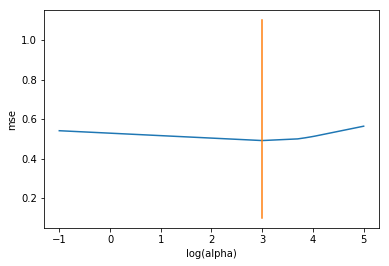

In [19]:
### 2.1 岭回归模型评价
mse_mean = np.mean(ridge.cv_values_, axis=0)

#正则项参数取对数， mse_mean.reshape() 干什么的？拉平
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas), 1))
# 在最佳参数位置绘制竖线：注意第二个参数值要和 Y 坐标轴匹配
plt.plot(np.log10(ridge.alpha_)*np.ones(3), [.1, .5, 1.1])
# plt.show() #绘制在一张图上，显示异常，暂时分开 

plt.xlabel('log(alpha)')
plt.ylabel('mse')
print('best alpha is:', ridge.alpha_)

In [20]:
# 模型评估
ridgeScoreTrain = ridge.score(train_X_ss, train_y_ss_1d)
ridgeScoreVal = ridge.score(val_X_ss, val_y_ss_1d)
print('The score: Train=%s  Val=%s'% (ridgeScoreTrain, ridgeScoreVal)) 

ridge_predict_train = ridge.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, ridge_predict_train) ** 0.5
ridge_predict_val = ridge.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, ridge_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6886471998505836  Val=0.5049070896778365
# The RMSE: Train=0.5579899841294994  Val=0.8149389859862378

The score: Train=0.5918621857750179  Val=0.46693490128866116
The RMSE: Train=0.638856605090579  Val=0.6494959947595185


### 保存校验集测试结果

In [21]:
print('ridge_predict_val= ', ridge_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(ridge_predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'RidgeCV'), index=False)
valPredict.head()

ridge_predict_val=  [-0.15949846 -0.1322065  -0.13789116 ... -0.14876283 -0.09742753
 -0.14121984]
predict =  [-11.63894155   5.58232386   1.99530022 ...  -4.86474444  27.52790997
  -0.10510644]


,user_id,prediction_pay_price
0,2922139,0.0000
1,300666,5.5823
2,2186429,1.9953
3,829992,17.1964
4,2324861,0.0000


In [22]:
#对测试数据进行预测
ridge_y_predict_test = ridge.predict(test_X_ss)
print('ridge_y_predict_test = ', ridge_y_predict_test)

# 标准化数据还原 
ridge_y_predict_test = inverse_StandardScaler(ridge_y_predict_test)

ridge_y_predict_test =  [-0.17890436 -0.17043465 -0.17102937 ... -0.14911914 -0.16608981
 -0.16478459]
predict =  [-23.88408987 -18.53969141 -18.91496128 ...  -5.08957517 -15.79809415
 -14.97449574]


In [23]:
# ridge_y_predict_test = move_up(ridge_y_predict_test)
#输出预测后的数据
testPredict = generate_summit(ridge_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'RidgeCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000


### 3. 正则化的线性回归 ElasticNetCV 

In [24]:
%%time
# l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
l1_ratio = [.99, 1]

model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.001) #效果最好
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.005)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.0005)
model.fit(train_X_ss, train_y_ss_1d)
print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.023491824547378765  l1_ratio_:1.0
# Wall time: 1min 17s

best alpha is:0.034230813157229346  l1_ratio_:1.0
Wall time: 2.08 s


best alpha is:0.034230813157229346  l1_ratio_:1.0


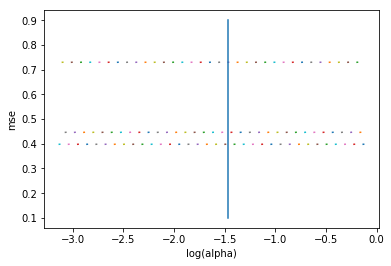

In [25]:
## 3.1 Lasso 模型评价
mses = np.mean(model.mse_path_, axis=1)
plt.plot(np.log10(model.alphas_), mses)

plt.plot(np.log10(model.alpha_)*np.ones(3), [0.1, 0.5, .9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')

print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.023491824547378765  l1_ratio_:1.0

In [26]:
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score of model: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, predict_train) ** 0.5
predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score of model: Train=0.5770046284899812  Val=0.6397112081154743
# The RMSE: Train=0.6503808356107215  Val=0.7399599188801825

The score of model: Train=0.5561720870824465  Val=0.4832887092059593
The RMSE: Train=0.6662040648194818  Val=0.6394555021034584


### 保存校验集测试结果

In [27]:
print('predict_val= ', predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'ElasticNetCV'), index=False)
valPredict.head()

predict_val=  [-0.12569921 -0.07998608 -0.13120922 ... -0.12569689 -0.10944689
 -0.07783093]
predict =  [ 9.68843706 38.53349097  6.21160888 ...  9.6899012  19.94367366
 39.89338989]


,user_id,prediction_pay_price
0,2922139,9.6884
1,300666,38.5335
2,2186429,6.2116
3,829992,17.6264
4,2324861,22.2024


In [28]:
#对测试数据进行预测
predict_test = model.predict(test_X_ss)
print('predict_test = ', predict_test)

# 标准化数据还原 
predict_test_true = inverse_StandardScaler(predict_test)

predict_test =  [-0.13472481 -0.13537084 -0.13537084 ... -0.13509857 -0.13538662
 -0.13538662]
predict =  [3.99326876 3.58562461 3.58562461 ... 3.75742501 3.57566662 3.57566662]


In [29]:
testPredict = generate_summit(predict_test_true)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'ElasticNetCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,3.9933
1,14934,3.5856
2,14935,3.5856
3,14936,4.1708
4,14937,3.5866
